In [7]:
import numpy as np
%load_ext autoreload
%autoreload 2

import torch
import sys

sys.path.append('..')

from algorithms.sequence_models.config import TrainConfig

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device is  cpu


In [8]:
import torch
import numpy as np

from algorithms.random_policy import RandomPolicy
from data.trajectory import TrajectoryDataset, TrajectoryData
from data.convertor import DiscreteStateConvertor, RewardConvertor, DiscreteActionConvertor, \
    Convertor


class CartpoleDataset(TrajectoryDataset):
    def __init__(self, env, n_trajectories=10000, reward_scale=None, prob_keeping_nonzero=0.1):
        super().__init__(gamma=1)

        self.env = env
        policy = RandomPolicy(self.env)
        self.trajectories = []
        many_random_trajs = self.collect_trajectories(self.env, policy, n_trajectories=n_trajectories)
        for traj in many_random_trajs:
            observations, actions, rewards, returns, dones = traj
            if returns[0] < 200:
                if np.random.random() < prob_keeping_nonzero:
                    self.trajectories.append(traj)
            else:
                self.trajectories.append(traj)
        # todo other policies maybe?

        self.original_obs_shape = env.observation_space.shape
        self.flattened_obs_dim = np.prod(self.original_obs_shape)

        all_state_features = []
        all_returns = []
        for observations, actions, rewards, returns, dones in self.trajectories:
            all_state_features.extend(list(observations))
            all_returns.append(returns[0])
        all_returns = np.array(all_returns)
        all_state_features = np.array(all_state_features)
        self.state_mean = np.mean(all_state_features, axis=0)
        self.state_std = np.std(all_state_features, axis=0)

        if reward_scale is None:
            self.reward_scale = np.abs(np.mean(all_returns)) + np.std(all_returns)  #  todo or maybe a consider the interval (including min)
        else:
            self.reward_scale = reward_scale

        self._state_convertor =  CartpoleStateConvertor(self.original_obs_shape, self.state_mean, self.state_std)
        self._reward_convertor = RewardConvertor(self.reward_scale)
        self._action_convertor = DiscreteActionConvertor(self.env.action_space)

        print("Dataset Info:")
        print('episode_max_length:', self.get_max_episode_length())
        print('reward_scale:', self.reward_scale)
        print(f'return min={all_returns.min()}, max={all_returns.max()} mean={all_returns.mean()}')
        # print('state_mean:', self.state_mean)
        # print('state_std:', self.state_std)
        print('gamma:', self.gamma)

    @property
    def state_convertor(self):
        return self._state_convertor

    @property
    def reward_convertor(self):
        return self._reward_convertor

    @property
    def action_convertor(self):
        return self._action_convertor

    def dataset_size(self):
        return len(self.trajectories)

    def get_item(self, item) -> TrajectoryData:
        observations, actions, rewards, returns, dones = self.trajectories[item]
        observations_features, actions_features, rewards_features, returns_features, dones_features = [], [], [], [], []
        for o, a, r, rt, d in zip(observations, actions, rewards, returns, dones):
            observations_features.append(self.state_convertor.to_feature_space(o))
            actions_features.append(self.action_convertor.to_feature_space(a))
            rewards_features.append(self.reward_convertor.to_feature_space(r))
            returns_features.append(self.reward_convertor.to_feature_space(rt))
            dones_features.append(d)

        return TrajectoryData(
            observations=np.array(observations_features),
            actions=np.array(actions_features),
            rewards=np.array(rewards_features),
            returns=np.array(returns_features),
            dones=np.array(dones_features)
        )

    def get_reward_scale(self):
        return self.reward_scale

    def state_dim(self):
        return self.flattened_obs_dim

    def action_dim(self):
        return self.env.action_space.n


class CartpoleStateConvertor(Convertor):
    def __init__(self, shape, state_mean, state_std):
        super().__init__()
        self.shape = shape
        self.state_mean = state_mean
        self.state_std = state_std
        self.state_std = np.where(self.state_std == 0, 1e-7, self.state_std)  # prevent overflow

    def to_feature_space(self, value):
        value = (value - self.state_mean) / self.state_std
        d = len(self.shape)
        value = value.reshape(list(value.shape[:-d]) + [-1])
        return value

    def from_feature_space(self, value):
        if isinstance(value, torch.Tensor):
            value = value.cpu().numpy()
        value = value.reshape(list(value.shape[:-1]) + list(self.shape))
        value = value * self.state_std + self.state_mean
        return value

In [11]:
from algorithms.sequence_models.decision_S4.dts4 import DecisionS4
from comparison_experiment import AutomatedComparisonExperiment
import gymnasium as gym
import pickle


env = gym.make('CartPole-v1')
env_human = gym.make('CartPole-v1', render_mode='human')

# policy = pickle.load(open('policy.pkl', 'rb'))
# from algorithms.evaluate_policy import evaluate_policy
# evaluate_policy(policy, env_human, num_eval_ep=20)

In [12]:
max_eval_ep_len = 510 # todo change for other envs
context_len = 512  # todo change for other envs (DECREASE TO IMPROVE SPEED)

config = TrainConfig(max_eval_ep_len=max_eval_ep_len, context_len=max_eval_ep_len, embed_dim = 32)

n_trajectories = 90_000 # todo is this enough / too much?
experiment_name = f"experiment_cartpole_dataset_size={n_trajectories}"
if CartpoleDataset.exists(experiment_name):
    traj_dataset = CartpoleDataset.load(experiment_name)
else:
    reward_scale = 1 # todo change for other envs
    traj_dataset = CartpoleDataset(env, n_trajectories=n_trajectories, reward_scale=reward_scale, prob_keeping_nonzero=0.01)
    traj_dataset.save(experiment_name)

comparison_experiment = AutomatedComparisonExperiment(
    env=env,
    traj_dataset=traj_dataset,
    config=config,
    device=device,
    rtgs_for_train_eval=[0, 100, 200, 300, 400, 500], # todo change for other envs
    rtgs_final_test=[0, 100, 200, 300, 400, 500], # todo change for other envs
    env_name=f"CartPole-v1", # todo change for other envs
    experiment_name="cartpole_after_debug"
)

collecting trajectories:   0%|          | 0/90000 [00:00<?, ?it/s]

Dataset Info:
episode_max_length: 75
reward_scale: 1
return min=8.0, max=75.0 mean=22.368653421633553
gamma: 1
s4 : number of parameters 142055
dt : number of parameters 169799


In [28]:
print(config)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TrainConfig(max_eval_ep_len=126, context_len=126, rtg_range_check=(0, 1), rtg_main=0, num_eval_ep=10, batch_size=64, lr=0.001, wt_decay=0.0001, warmup_steps=10000, max_train_iters=200, num_updates_per_iter=100, model_checkpoint_interval=30, eval_model_interval=30, n_blocks=3, embed_dim=128, n_heads=1, dropout_p=0.1)


distribution of rewards in the dataset
training started


  0%|          | 0/200 [00:00<?, ?it/s]

time elapsed: 0:00:08
num of updates: 100
loss: 0.76823
lr 0.00001
grad_norm 0.14009
time elapsed: 0:00:16
num of updates: 200
loss: 0.57080
lr 0.00002
grad_norm 0.14349
time elapsed: 0:00:24
num of updates: 300
loss: 0.33422
lr 0.00003
grad_norm 0.13523
time elapsed: 0:00:33
num of updates: 400
loss: 0.27143
lr 0.00004
grad_norm 0.08013
time elapsed: 0:00:41
num of updates: 500
loss: 0.26007
lr 0.00005
grad_norm 0.06578
time elapsed: 0:00:49
num of updates: 600
loss: 0.25611
lr 0.00006
grad_norm 0.07090
time elapsed: 0:00:57
num of updates: 700
loss: 0.25429
lr 0.00007
grad_norm 0.10429
time elapsed: 0:01:06
num of updates: 800
loss: 0.25308
lr 0.00008
grad_norm 0.14327
time elapsed: 0:01:14
num of updates: 900
loss: 0.25234
lr 0.00009
grad_norm 0.03185
time elapsed: 0:01:22
num of updates: 1000
loss: 0.25156
lr 0.00010
grad_norm 0.03930
time elapsed: 0:01:30
num of updates: 1100
loss: 0.25121
lr 0.00011
grad_norm 0.10292
time elapsed: 0:01:38
num of updates: 1200
loss: 0.25090
lr 0.0

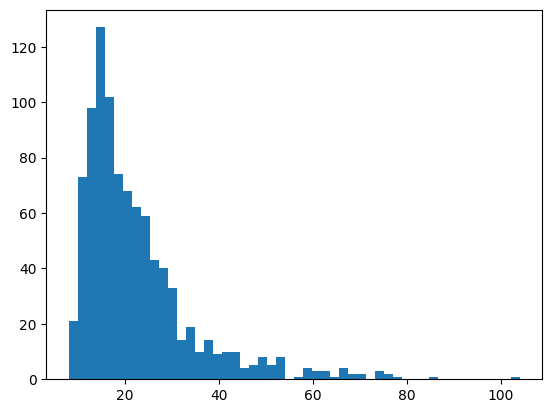

<Figure size 640x480 with 0 Axes>

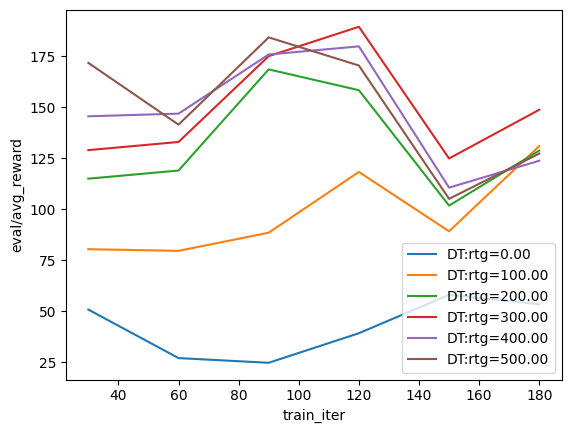

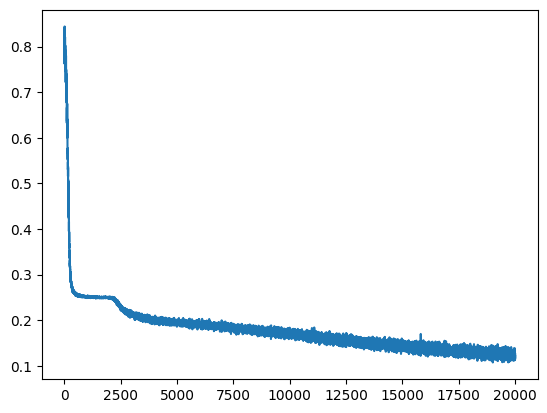

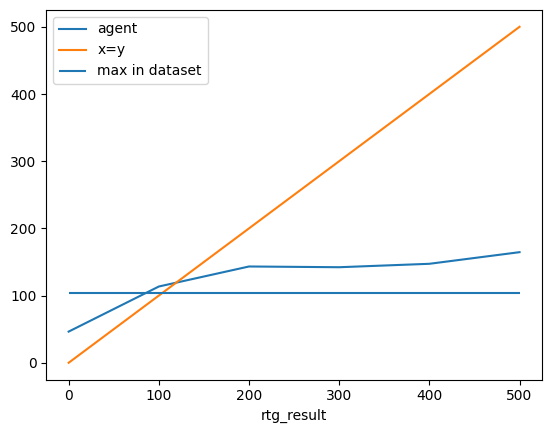

In [31]:
comparison_experiment.run_and_report(comparison_experiment.dt_experiment,200)

In [32]:
from algorithms.evaluate_policy import evaluate_policy

policy = comparison_experiment.make_dt_policy(rtg=1)
evaluate_policy(policy, env_human, num_eval_ep=20)

{'eval/avg_reward': 48.4, 'eval/avg_ep_len': 48.4}

In [33]:
! zip figures_zip.zip -r RL-credit-assignment-experiment/figures
! zip logs.zip -r RL-credit-assignment-experiment/logs

from google.colab import files
files.download('figures_zip.zip')
files.download('logs.zip')

  adding: RL-credit-assignment-experiment/figures/ (stored 0%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=944_loss_after=200.png (deflated 13%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=944__rtg_following_iters=200.png (deflated 11%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=10000_loss_after=10.png (deflated 10%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=944_distribution_of_returns_in_trajectories.png (deflated 26%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=536_distribution_of_returns_in_trajectories.png (deflated 26%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=536_loss_after=10.png (deflated 11%)
  adding: RL-credit-assignment-experiment/figures/CartPole-v1_dt_cartpole_after_debug_size=10000_distri

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>